# EDA 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import os
import glob
import seaborn as sns
import urllib.request

plt.style.use('ggplot')

DATA_PATH = 'data/'

In [ ]:
# 50 animal categories
classes = [
    "ant", "bat", "bear", "bee", "bird", "butterfly", "camel", "cat", "cow", 
    "crab", "crocodile", "dog", "dolphin", "dragon", "duck", "elephant", "fish", 
    "flamingo", "frog", "giraffe", "hedgehog", "horse", "kangaroo", "lion", 
    "lobster", "mermaid", "monkey", "mosquito", "mouse", "octopus", "owl", 
    "panda", "parrot", "penguin", "pig", "rabbit", "raccoon", "rhinoceros", 
    "scorpion", "sea turtle", "shark", "sheep", "snail", "snake", "spider", 
    "squirrel", "swan", "tiger", "whale", "zebra"
]

os.makedirs('data', exist_ok=True)
base_url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'

print(f"Targeting {len(classes)} classes.")
print("Checking data...")

for c in classes:
    safe_c = c.replace(' ', '%20')
    path = f'data/{c}.npy'
    if not os.path.exists(path):
        print(f'Downloading {c}...')
        try:
             urllib.request.urlretrieve(f'{base_url}{safe_c}.npy', path)
        except Exception as e:
            print(f"Error downloading {c}: {e}")

print("Data ready.")

Targeting 50 classes.
Checking data...
All data is ready.


In [ ]:
# inspect cat data structure
cat_data = np.load('data/cat.npy')

print(f"Shape: {cat_data.shape}")
print(f"Pixel range: {cat_data.min()} - {cat_data.max()}")
print(f"Dtype: {cat_data.dtype}")

Raw shape: (123202, 784)
Min pixel value: 0
Max pixel value: 255
Data type: uint8


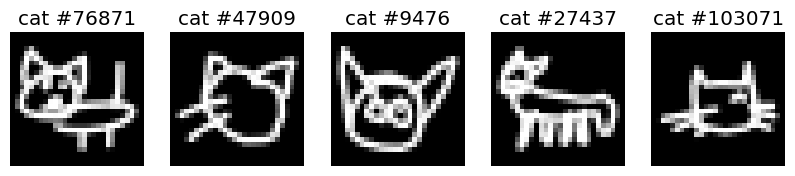

In [ ]:
def plot_samples(category, n=5):
    data = np.load(f'data/{category}.npy')
    indices = np.random.randint(0, len(data), size=n)
    
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(indices):
        plt.subplot(1, n, i+1)
        img = data[idx].reshape(28, 28)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f"{category} #{idx}")
    plt.show()

plot_samples('cat')

In [ ]:
files = glob.glob('data/*.npy')

counts = {}
for f in files:
    try:
        data = np.load(f, mmap_mode='r')
        name = f.split('/')[-1].replace('.npy', '')
        counts[name] = len(data)
    except Exception as e:
        print(f"Error reading {f}: {e}")

if counts:
    df_counts = pd.DataFrame(list(counts.items()), columns=['Category', 'Count'])
    fig = px.bar(df_counts, x='Category', y='Count', title="Images per Category", text='Count')
    fig.show()
    print(f"Min: {min(counts.values())}, Max: {max(counts.values())}")
else:
    print("No .npy files found.")

Min samples: 113613
Max samples: 253791


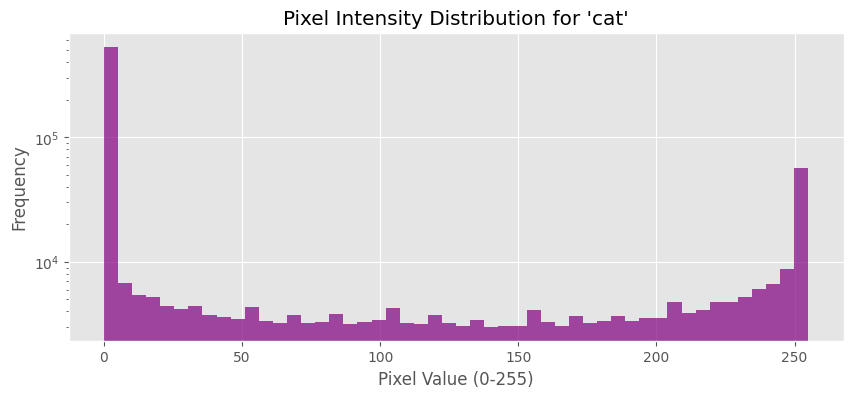

In [ ]:
def check_pixel_distribution(category):
    data = np.load(f'data/{category}.npy')
    all_pixels = data[:1000].flatten()
    
    plt.figure(figsize=(10, 4))
    plt.hist(all_pixels, bins=50, color='purple', alpha=0.7)
    plt.title(f"Pixel Distribution: {category}")
    plt.xlabel("Pixel Value (0-255)")
    plt.ylabel("Frequency")
    plt.yscale('log')
    plt.show()

check_pixel_distribution('cat')

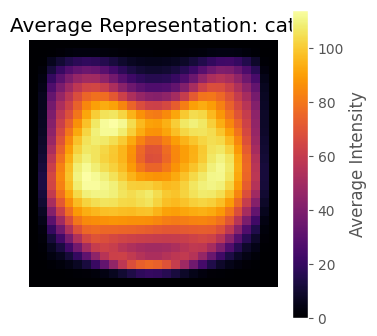

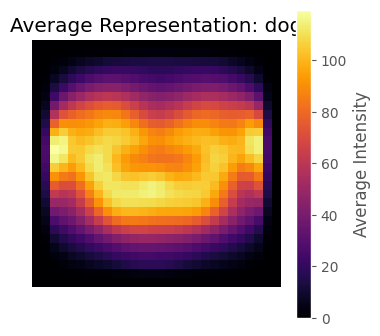

In [ ]:
def plot_average_image(category):
    data = np.load(f'data/{category}.npy')
    mean_img = data.mean(axis=0).reshape(28, 28)
    
    plt.figure(figsize=(4, 4))
    plt.imshow(mean_img, cmap='inferno') 
    plt.title(f"Average: {category}")
    plt.axis('off')
    plt.colorbar(label='Intensity')
    plt.show()

plot_average_image('cat') 
plot_average_image('dog')

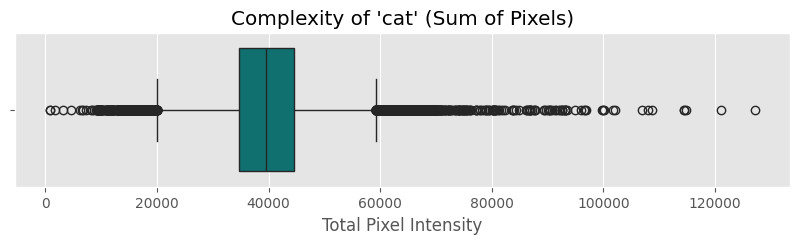

Found 2 suspicious/empty drawings.


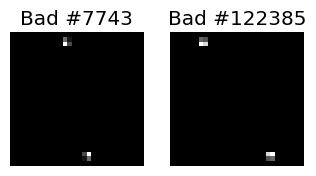

In [ ]:
def find_outliers(category):
    data = np.load(f'data/{category}.npy')
    pixel_sums = data.sum(axis=1)
    
    plt.figure(figsize=(10, 2))
    sns.boxplot(x=pixel_sums, color='teal')
    plt.title(f"Drawing Complexity: {category}")
    plt.xlabel("Total Pixel Intensity")
    plt.show()
    
    empty_indices = np.where(pixel_sums < 1000)[0]
    
    if len(empty_indices) > 0:
        print(f"Found {len(empty_indices)} near-empty drawings.")
        plt.figure(figsize=(10, 2))
        for i, idx in enumerate(empty_indices[:5]):
            plt.subplot(1, 5, i+1)
            plt.imshow(data[idx].reshape(28, 28), cmap='gray')
            plt.axis('off')
            plt.title(f"#{idx}")
        plt.show()
    else:
        print("No empty drawings.")

find_outliers('cat')

## Data Prep
Limit to 15k samples per class, normalize pixels, split into train/test.

In [ ]:
from sklearn.model_selection import train_test_split

available_classes = [c for c in classes if os.path.exists(f'data/{c}.npy')]
class_to_idx = {name: idx for idx, name in enumerate(available_classes)}
idx_to_class = {idx: name for name, idx in class_to_idx.items()}

MAX_SAMPLES_PER_CLASS = 15000 
TEST_SIZE = 0.2

X_data = []
y_data = []

print(f"Loading {MAX_SAMPLES_PER_CLASS} samples per class...")

for category in available_classes:
    data = np.load(f'data/{category}.npy')
    data = data[:MAX_SAMPLES_PER_CLASS]
    data = data.astype('float32') / 255.0
    
    label = class_to_idx[category]
    labels = np.full(len(data), label)
    
    X_data.append(data)
    y_data.append(labels)

X = np.concatenate(X_data, axis=0)
y = np.concatenate(y_data, axis=0)

print(f"Dataset: {X.shape}, {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=42, stratify=y
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Class mappings defined for 50 classes.
Loading up to 15000 samples per class...
Total Dataset: X=(750000, 784), y=(750000,)
Train: X=(600000, 784), y=(600000,)
Test:  X=(150000, 784), y=(150000,)


## Model Training
Train a CNN with batch normalization and dropout.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

print("GPUs:", len(tf.config.list_physical_devices('GPU')))

X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

print(f"Input shape: {X_train_cnn.shape}")

2026-01-14 17:14:49.199687: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-14 17:14:49.839729: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-14 17:14:51.920562: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Num GPUs Available:  1
CNN input shape: (600000, 28, 28, 1)


In [ ]:
def build_model(num_classes, learning_rate=0.001, dropout_rate=0.4, dense_units=512, start_filters=64):
    inputs = layers.Input(shape=(28, 28, 1))
    
    # block 1
    x = layers.Conv2D(start_filters, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(start_filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # block 2
    x = layers.Conv2D(start_filters * 2, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(start_filters * 2, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # block 3
    x = layers.Conv2D(start_filters * 4, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(start_filters * 4, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # block 4
    x = layers.Conv2D(start_filters * 8, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dense(dense_units)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    
    x = layers.Dense(dense_units // 2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-4)
    
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    return model

early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    mode='max'
)

lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

print("Model ready.")

Model architecture ready.


In [ ]:
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.08,
    fill_mode='nearest'
)

param_grid = {
    'learning_rate': [0.001],
    'dropout_rate': [0.4],
    'dense_units': [512]
}

keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Training {len(combinations)} config(s)...")

best_acc = 0
best_model = None
best_params = {}
history_best = None

for params in combinations:
    print(f"\nParams: {params}")
    
    model = build_model(
        num_classes=len(available_classes),
        learning_rate=params['learning_rate'],
        dropout_rate=params['dropout_rate'],
        dense_units=params['dense_units']
    )
    
    print(f"Parameters: {model.count_params():,}")
    
    history = model.fit(
        datagen.flow(X_train_cnn, y_train, batch_size=128),
        steps_per_epoch=len(X_train_cnn) // 128,
        epochs=40,
        validation_data=(X_test_cnn, y_test),
        callbacks=[early_stopping, lr_scheduler],
        verbose=1 
    )
    
    val_acc = max(history.history['val_accuracy'])
    print(f"\nVal Accuracy: {val_acc:.4f}")
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = model
        best_params = params
        history_best = history

print(f"\nDone. Best: {best_acc:.4f}")

Training 1 configuration(s) for maximum accuracy...
Target: 85%+ validation accuracy

Params: {'learning_rate': 0.001, 'dropout_rate': 0.4, 'dense_units': 512}


I0000 00:00:1768391093.116873   19988 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5560 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model parameters: 2,739,954
Epoch 1/40


2026-01-14 17:14:59.325306: I external/local_xla/xla/service/service.cc:163] XLA service 0x7468a80028e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-14 17:14:59.325439: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2026-01-14 17:14:59.461629: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-14 17:15:00.181688: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2026-01-14 17:15:00.454457: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-01-14 17:15:00.

   2/4687 ━━━━━━━━━━━━━━━━━━━━ 5:39 72ms/step - accuracy: 0.0137 - loss: 4.4558       

I0000 00:00:1768391107.898381   21144 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4371/4687 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.4678 - loss: 2.0095

2026-01-14 17:16:27.648593: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-01-14 17:16:27.648871: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-01-14 17:16:27.648969: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-01-14 17:16:27.648979: I external/l

4686/4687 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4755 - loss: 1.9783

2026-01-14 17:16:42.104457: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-01-14 17:16:42.357511: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_292', 4 bytes spill stores, 4 bytes spill loads

2026-01-14 17:16:42.635797: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_292', 48 bytes spill stores, 48 bytes spill loads

2026-01-14 17:16:42.764191: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_292', 80 bytes s

4687/4687 ━━━━━━━━━━━━━━━━━━━━ 124s 24ms/step - accuracy: 0.5850 - loss: 1.5331 - val_accuracy: 0.6913 - val_loss: 1.1044 - learning_rate: 0.0010
Epoch 2/40
   1/4687 ━━━━━━━━━━━━━━━━━━━━ 1:47 23ms/step - accuracy: 0.6719 - loss: 1.3393

/home/manu/miniconda3/envs/tf-env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



4687/4687 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.6719 - loss: 1.3393 - val_accuracy: 0.6949 - val_loss: 1.0922 - learning_rate: 0.0010
Epoch 3/40
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 98s 21ms/step - accuracy: 0.6965 - loss: 1.1033 - val_accuracy: 0.7244 - val_loss: 0.9796 - learning_rate: 0.0010
Epoch 4/40
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7734 - loss: 0.8596 - val_accuracy: 0.7236 - val_loss: 0.9837 - learning_rate: 0.0010
Epoch 5/40
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 96s 21ms/step - accuracy: 0.7256 - loss: 0.9950 - val_accuracy: 0.7459 - val_loss: 0.9036 - learning_rate: 0.0010
Epoch 6/40
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.7500 - loss: 0.8346 - val_accuracy: 0.7460 - val_loss: 0.9028 - learning_rate: 0.0010
Epoch 7/40
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 95s 20ms/step - accuracy: 0.7429 - loss: 0.9322 - val_accuracy: 0.7597 - val_loss: 0.8534 - learning_rate: 0.0010
Epoch 8/40
4687/4687 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.7266 - lo

## Evaluation

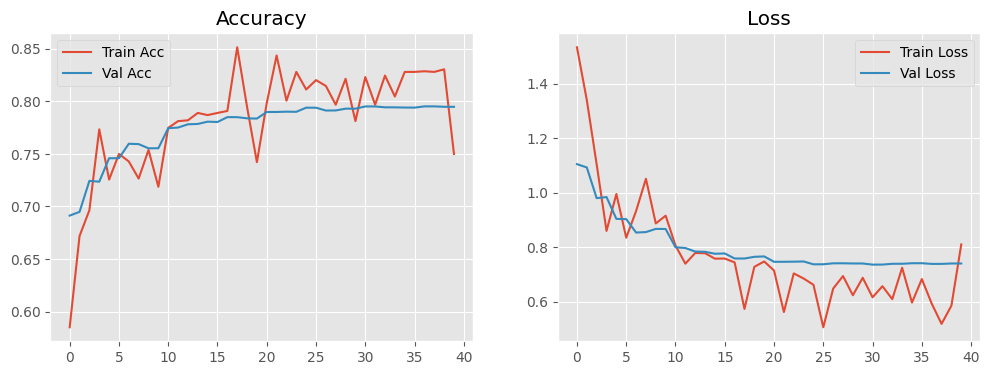

In [ ]:
acc = history_best.history['accuracy']
val_acc = history_best.history['val_accuracy']
loss = history_best.history['loss']
val_loss = history_best.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train')
plt.plot(val_acc, label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train')
plt.plot(val_loss, label='Val')
plt.title('Loss')
plt.legend()
plt.show()


PER-CLASS PERFORMANCE ANALYSIS
              precision    recall  f1-score   support

         ant      0.877     0.845     0.861      3000
         bat      0.815     0.832     0.823      3000
        bear      0.587     0.490     0.534      3000
         bee      0.887     0.901     0.894      3000
        bird      0.630     0.572     0.599      3000
   butterfly      0.948     0.957     0.953      3000
       camel      0.942     0.907     0.924      3000
         cat      0.751     0.753     0.752      3000
         cow      0.692     0.768     0.728      3000
        crab      0.813     0.825     0.819      3000
   crocodile      0.819     0.822     0.820      3000
         dog      0.605     0.531     0.565      3000
     dolphin      0.850     0.747     0.795      3000
      dragon      0.616     0.703     0.657      3000
        duck      0.680     0.672     0.676      3000
    elephant      0.819     0.820     0.820      3000
        fish      0.888     0.904     0.896      

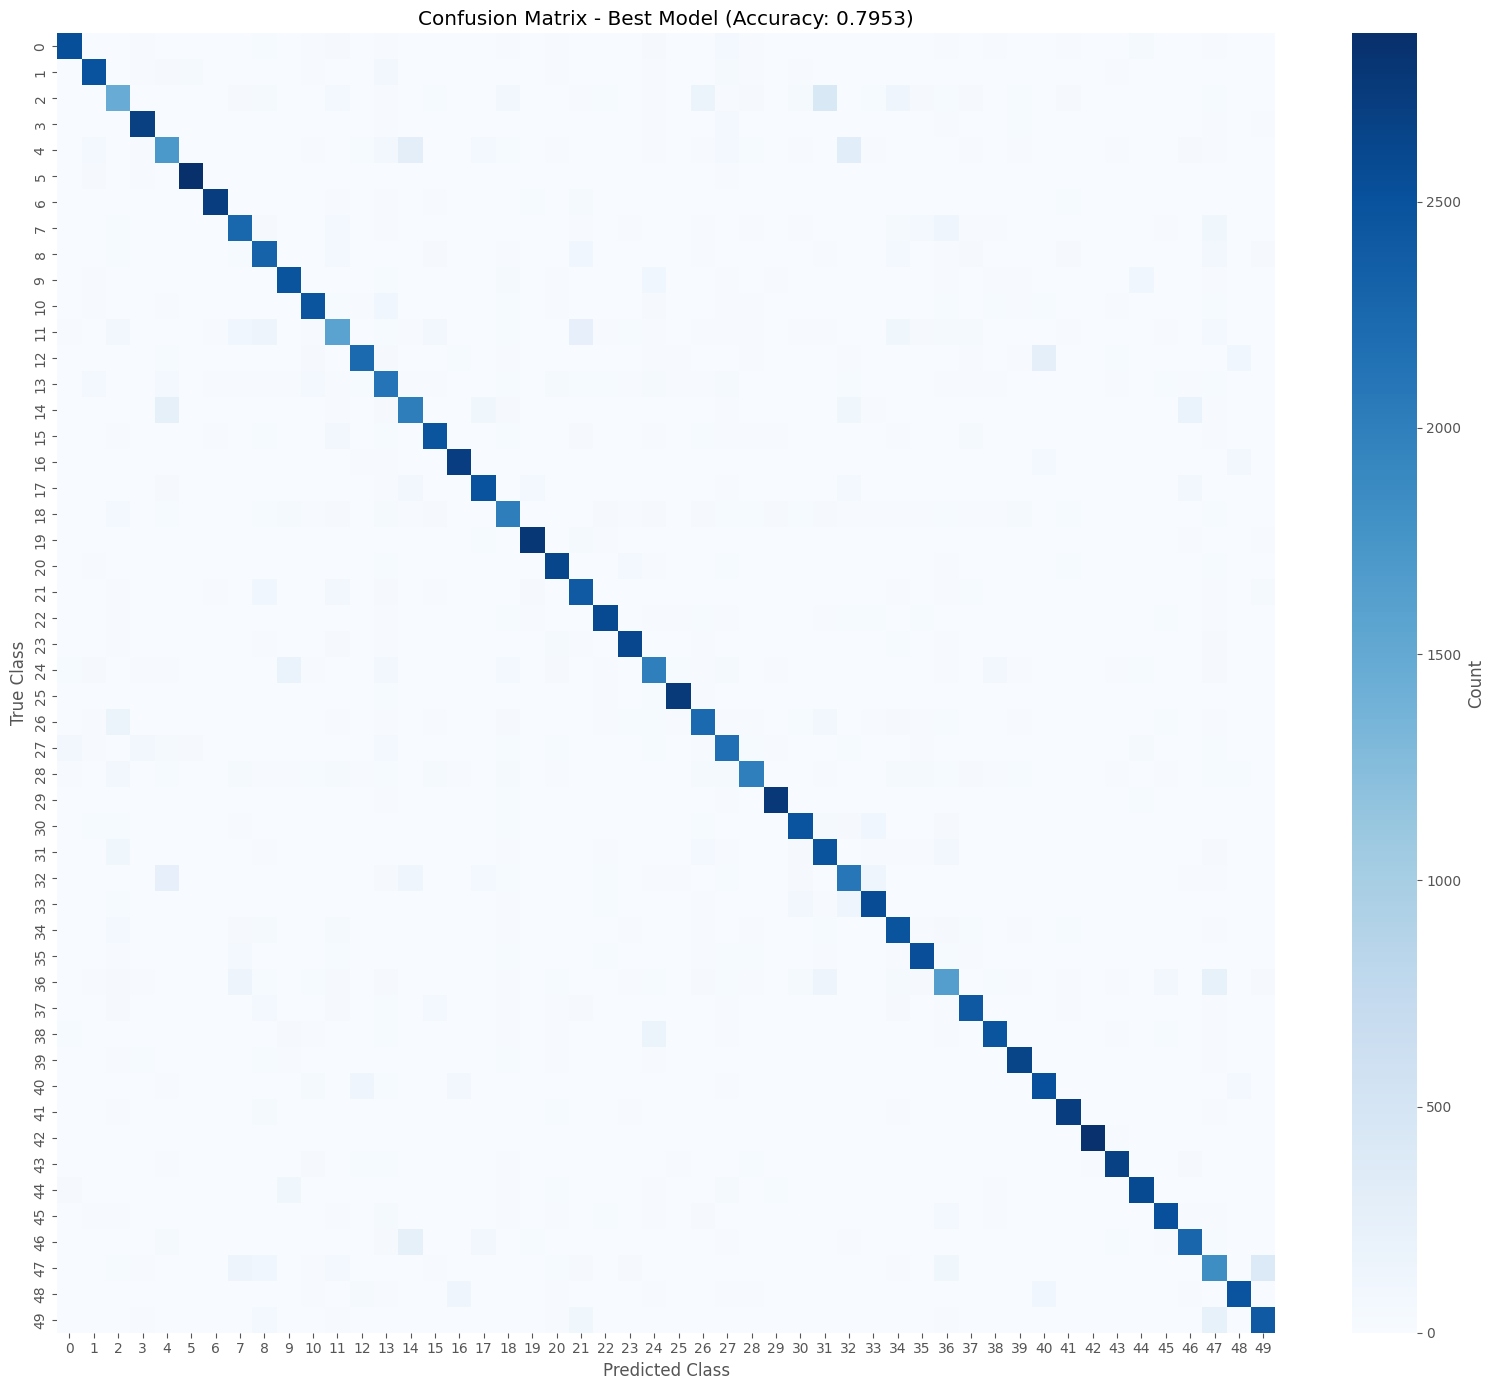


DETAILED MISCLASSIFICATION ANALYSIS

'bear' is most often confused with:
  -> panda                (427 times)
  -> monkey               (178 times)
  -> pig                  (140 times)
  -> frog                 (86 times)
  -> dog                  (67 times)

'dog' is most often confused with:
  -> horse                (242 times)
  -> cow                  (156 times)
  -> pig                  (115 times)
  -> cat                  (101 times)
  -> bear                 (99 times)

'raccoon' is most often confused with:
  -> tiger                (225 times)
  -> cat                  (157 times)
  -> panda                (147 times)
  -> squirrel             (96 times)
  -> owl                  (55 times)

Best model saved to doodle_cnn_best.keras
Final Validation Accuracy: 0.7953 (77%)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

y_pred = best_model.predict(X_test_cnn, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=available_classes, digits=3))

f1_per_class = f1_score(y_test, y_pred_classes, average=None, labels=range(len(available_classes)))

print("\nLowest F1 classes:")
worst_indices = np.argsort(f1_per_class)[:10]
for idx in worst_indices:
    print(f"  {available_classes[idx]:20s} F1: {f1_per_class[idx]:.3f}")

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Acc: {best_acc:.4f})')
plt.tight_layout()
plt.show()

print("\nMisclassification analysis:")
for worst_idx in worst_indices[:3]:
    class_name = available_classes[worst_idx]
    true_mask = (y_test == worst_idx)
    preds = y_pred_classes[true_mask]
    wrong = preds[preds != worst_idx]
    
    if len(wrong) > 0:
        unique, counts = np.unique(wrong, return_counts=True)
        top = unique[np.argsort(-counts)[:3]]
        print(f"\n'{class_name}' confused with:")
        for c_idx in top:
            cnt = counts[np.where(unique == c_idx)[0][0]]
            print(f"  {available_classes[c_idx]:20s} ({cnt}x)")

best_model.save('doodle_cnn_best.keras')
print(f"\nModel saved. Accuracy: {best_acc:.4f}")